In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pywt


import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

from keras.utils import to_categorical
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.svm import SVC

ModuleNotFoundError: No module named 'sklearn'

In [34]:
root_dir = str('/home/surya/Desktop/WiFi_Sensing_2.0/dataset/')

In [35]:
#%%
data = []
labels = []

with h5py.File(root_dir + 'dataset_FINAL5.hdf5', 'r') as hf:
    X = hf.get('X')
    data = np.array(X)
    Y = hf.get('Y')
    labels = np.array(Y)
hf.close()

In [ ]:
print(data.shape)
print(labels.shape)
'''
0 - still
1 - walking
2 - waving
3 - page turning
4 - phone picking
'''
print(labels)

labels_list = ['still', 'walking', 'waving', 'page turning', 'phone picking']
print(labels_list)


### Visualisation

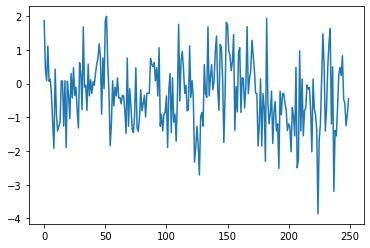

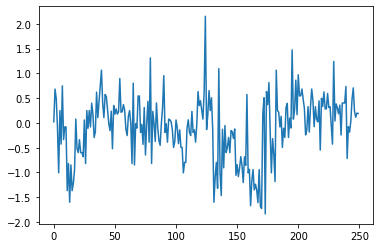

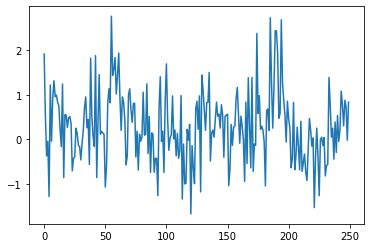

In [37]:
plt.plot(data[90,:,100])
plt.show()

plt.plot(data[165,:,100])
plt.show()

plt.plot(data[2,:,100])
plt.show()

### DEnoising

In [38]:
'''
Performs wavelet denoising !!!

http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
'''

def denoise(signal, thresh ,title = None, wavelet="db5"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    #print(np.shape(coeff))
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return  np.round(reconstructed_signal,decimals = 2)

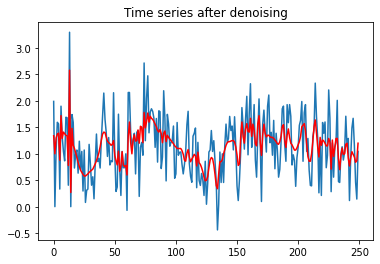

In [39]:
time_data = data[150,:,100]
denoised = denoise(signal = time_data,thresh = 0.2 )
plt.plot(time_data)
plt.plot(denoised,color = 'r')
plt.title("Time series after denoising")
plt.show()

### Bringing everything together 
 
1. Data 
2. Denoise using  DWT 
3. Extract eigen values 
4. find the diff between them and sum if to find the features 
5. Run an SVM model

In [163]:
class time_series2features():

    def __init__(self,data, DWT_thresh = 0.45):
        assert data.shape[1] ==  192 ,'data shape shd be (*,subcarriers , *)'
        self.data = data
        self.DWT_thresh = DWT_thresh
        

    def extract_features(self):

        self.data_eigen_feat = []
        self.denoised_data = np.zeros(self.data.shape)
        for i in range((self.data.shape[0])):
            datapoint =  self.data[i]
            denoised_datapoint = time_series2features.denoise_datapoint(datapoint, thresh=self.DWT_thresh)
        
            self.denoised_data[i] = denoised_datapoint
            self.data_eigen_feat.append(self.extract_eigen_feat(denoised_datapoint))

        return np.array(self.data_eigen_feat)
            
        
    ####################################################################



    @staticmethod
    ## given a time series of the dim (len, 1) return the denoised version...
    def denoise_sc(signal, thresh ,title = None, wavelet="db5"):
        thresh = thresh*np.nanmax(signal)
        coeff = pywt.wavedec(signal, wavelet, mode="per" )
        coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
        reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
        return  np.round(reconstructed_signal,decimals = 2)

    @staticmethod
    ## given an data point shape(sc,len of time )
    def denoise_datapoint(datapoint_arr,thresh):
        temp = np.zeros(datapoint_arr.shape)
        for sc in range(datapoint_arr.shape[0]):
            temp[sc,:] = time_series2features.denoise_sc(datapoint_arr[sc,:], thresh = thresh)
            temp[np.isnan(temp)] = 0
            temp[np.isposinf(temp)]=0
            temp[np.isneginf(temp)]=0
            
        return temp

    ######################################################################

    ########################################################################
    ## extract eigen features ..

    def extract_eigen_feat(self, datapoint):
        
        _,cov = time_series2features.normalizing_mat(datapoint)
        eig_vecs = time_series2features.eigendecomposition(cov,25)
        feat_lis = time_series2features.extractfeatures(eig_vecs)
        return feat_lis
    
    @staticmethod
    def normalizing_mat(arr):
        ## arr shd be of the shape (sub carreir vs len)
        arr = arr.T
        normed =(arr - arr.mean(axis=0)) / (arr.std(axis=0)+ 0.001)
        #print("The shape of normed is", normed.shape)
        cov = np.cov(normed.T)
        return normed,cov

    @staticmethod
    def eigendecomposition(array,k):
        eig_values, eig_vectors = np.linalg.eig(array)
        idx = np.argsort(eig_values, axis=0)[::-1]
        sorted_eig_vectors = eig_vectors[:, idx]
        cumsum = np.cumsum(eig_values[idx]) / np.sum(eig_values[idx])
        xint = range(1, len(cumsum) + 1)
        
        '''
        plt.figure(figsize = (10,10))
        plt.plot(xint, cumsum)
        plt.xlabel("Number of components")
        plt.ylabel("Cumulative explained variance")
        #plt.xticks(xint)
        #plt.xlim(1, 192, 1)
        '''
        req_eig_vectors = sorted_eig_vectors[:, 0:k]
        return req_eig_vectors

    @staticmethod
    def diff(array):
        sum = 0
        for i in range(1,len(array)):
            sum = sum + abs(array[i] - array[i-1])
        sum = sum / len(array)-1
        return sum

    @staticmethod
    def extractfeatures(array):
        lis = np.zeros(array.shape[1])
        for i in range(array.shape[1]):
            temp = array[:,i]
            lis[i] = time_series2features.diff(temp)
        return lis
    #######################################################################
    

In [164]:
### testing ...
new_data = data.swapaxes(2,1)
print(new_data[0].shape)
test = time_series2features(new_data)
eigen_feat = test.extract_features()


(192, 250)


In [166]:
X_feat = eigen_feat

In [168]:
print(X_feat[1])

[-0.98840058 -0.9842531  -0.98499396 -0.96345258 -0.95356674 -0.96307387
 -0.95439004 -0.94228701 -0.97625339 -0.93797321 -0.93629589 -0.93378772
 -0.93912978 -0.93980741 -0.93451114 -0.93402745 -0.92551709 -0.94209335
 -0.93528361 -0.93704534 -0.93830118 -0.93254029 -0.92822651 -0.93076463
 -0.92656513]


In [ ]:
print(labels)

In [225]:

X_list = []
labels_list = []
for i in range(0,5):

    labels_i_idx,_= np.where(labels==i)
    

    X_i = X_feat[labels_i_idx]
    
    X_list.append(X_i)

    labels_i = labels[labels_i_idx]
    labels_list.append(labels_i)

In [226]:
full_X = np.concatenate(X_list,axis=0)
full_labels = np.concatenate(labels_list,axis=0)

In [ ]:
basic_X = np.concatenate(X_list[0:2],axis=0)
basic_labels = np.concatenate(labels_list[0:2],axis=0)
print(basic_labels)

In [234]:
num_folds = 3
# Define per-fold score containers
pre_per_fold = []
acc_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)
inputs =  basic_X
targets = basic_labels

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs,targets):

    trainX,trainY = inputs[train],targets[train]
    trainY = trainY.reshape(trainX.shape[0],1)
    testX,testY = inputs[test],targets[test]
    testY = testY.reshape(testX.shape[0],1)


    set_train = np.concatenate((trainX,trainY),axis=1)
    set_test = np.concatenate((testX,testY),axis=1)
    '''
    print('----------------------------------------------------------------------')

    print(f'Training for fold {fold_no} ...')
    '''
    model = SVC(kernel='rbf')
    classifier = model.fit(trainX,trainY)

    y_pred = model.predict(testX) 
    targs = np.array(testY)
    
    targs = np.reshape(targs,(targs.shape[0],))

    preds = y_pred

    for i in range(len(y_pred)):
        if (y_pred[i] == -1):
            y_pred[i] = 0   

    scores = np.array([metrics.accuracy_score(targs, preds),metrics.precision_score(targs, preds)])
    print(f'Score for fold {fold_no}: acc of {scores[0]}; precision of {scores[1]*100}%')


NameError: name 'KFold' is not defined